In [1]:
import pymc

import hddm

In [2]:
import hddm
import bauer
import numpy as np

In [3]:
from bauer.utils.data import load_garcia2022

In [4]:
df = load_garcia2022()
df['response'] = (df['choice']).astype(np.float)
df['subj_idx'] = df.index.get_level_values('subject')

df['rt'] = df['rt'] / 1000.


df['log(n2/n1)'] = np.log(df['n2'] / df['n1'])

df['log_n1'] = np.log(df['n1'])
df['log_n2'] = np.log(df['n2'])

/tmp/ipykernel_1478/2964034845.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['response'] = (df['choice']).astype(np.float)


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


# sns.relplot(x='log_n1', y='choice', data=df.reset_index(), kind='line')
# sns.relplot(x='log(n2/n1)', y='response', data=df.reset_index(), kind='line')
# plt.axvline(0.0, c='k', ls='--')

In [6]:
model = hddm.HDDMRegressor(df.loc[:10], models=['v ~ 0 + log_n1 + log_n2'],
                           include=['v', 'a', 't', 'z'],
                           group_only_regressors=False,
                            is_group_model=False,
                           )

trace = model.sample(100, return_infdata=True, dbname='traces.pkl', db='pickle')

Adding these covariates:
['v_log_n1', 'v_log_n2']
 [-----------------101%-----------------] 101 of 100 complete in 8.3 sechddm sampling elpased time:  8.553 s
Start converting to InferenceData...


In [7]:
ppc_data = hddm.utils.post_pred_gen(model)

Start generating posterior prediction...


ValueError: Length of names must match number of levels in MultiIndex.

In [ ]:
trace.posterior['v_log_n1'].values

array([[0.53266299, 0.5782745 , 0.72977154, 0.75591994, 0.78422973,
        0.7533981 , 0.71418161, 0.71527414, 0.71872232, 0.69200335,
        0.68736021, 0.70108579, 0.67799946, 0.6674408 , 0.64583408,
        0.67566563, 0.67519792, 0.67280272, 0.6626725 , 0.65904997,
        0.65794358, 0.68675317, 0.66716169, 0.67586957, 0.72320458,
        0.69413755, 0.67330021, 0.68607684, 0.6948775 , 0.73749101,
        0.72478866, 0.72007745, 0.71928222, 0.73026803, 0.73754738,
        0.73828476, 0.7289173 , 0.71419933, 0.74505458, 0.75318823,
        0.76104389, 0.76995739, 0.78735154, 0.78569688, 0.78611277,
        0.76507864, 0.77966221, 0.78188495, 0.7660252 , 0.75873346,
        0.73443648, 0.744242  , 0.74363256, 0.74600892, 0.74328173,
        0.74328911, 0.75086504, 0.74808967, 0.75513446, 0.73710767,
        0.741726  , 0.69312786, 0.67053023, 0.62834143, 0.6495376 ,
        0.6254581 , 0.63427497, 0.65133329, 0.68299598, 0.66078816,
        0.69305903, 0.69505734, 0.68702269, 0.69

(array([ 5.,  7., 12.,  5., 15., 21., 25.,  9.,  0.,  1.]),
 array([0.01033775, 0.03669518, 0.06305262, 0.08941005, 0.11576748,
        0.14212492, 0.16848235, 0.19483979, 0.22119722, 0.24755465,
        0.27391209]),
 <BarContainer object of 10 artists>)

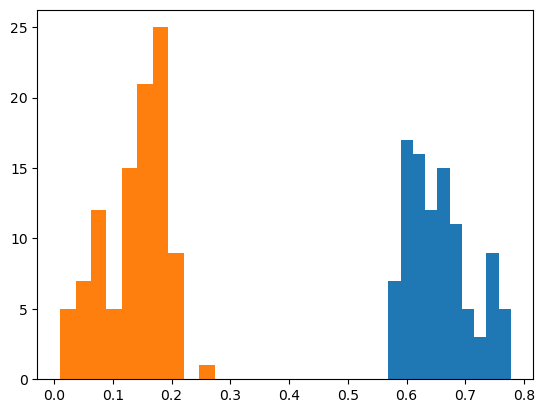

In [8]:
plt.hist(trace.posterior['v_log_n1'].to_dataframe())
plt.hist(trace.posterior['v_log_n2'].to_dataframe())
# sns.distplot(trace.posterior['v_log_n2'])